---
#### Описание данных


Вам представлены данные о доходах сотрудников участка горячего проката за год, в том числе данные, описывающие специфику рабочих мест.

Доход состоит из оклада, премии, доплат и индивидуальных надбавок. Данных об их размерах не приводится, так как именно их Вам предстоит восстановить.

---

#### Задание

 - Выявите формулу дохода в целом и его составных частей
 - Проверьте, что данная формула объясняет доход с точностью до рубля
 - Выявите зависимости между составными частями дохода



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

%matplotlib inline

Загрузим и изучим данные

In [2]:
df = pd.read_excel('salary.xlsx', parse_dates=['Месяц'])

In [6]:
df = df.rename(columns={'FIO': 'name', 
                   'Месяц': 'month', 
                   'Профессия': 'profession', 
                   'Разряд': 'category', 
                   'Оборудование': 'equipment',
                   'Вредность (балл.)': 'harm', 
                   'Объем производства': 'production_volume', 
                   'Доход': 'income'})

In [38]:
int((21180.18 - 20723.03) / (1250 - 1200)) == int((18437.29 - 17523) / (950 - 850))

True

Проверка выполняется, int нужен, тк из за округления какие то знаки после запятной могут не совпадать

В таблицу добавим величину перевыполнения плана, если план недовыполнен примем ее за 0

In [39]:
def over(s):
    l = []
    for i in s:
        if i > 850:
            a = (i - 850)
        else:
            a = 0
        l.append(a)
    return l
df['over_production_volume'] = over(df.production_volume)

Будем исходить из того, что доход состоит из оклада, премии, доплат и индивидуальных надбавок, 

```income = salary_scale + prize + add_payment + individual_payment```

Мы выяснили что надбавка за первыполнение плана начинается с 850, и вывели столбец *over_production_volume*, показыающий объем перевыполнения плана



**Попробуем рассчитать доплату за вредность**

In [69]:
df.head(7)

,name,month,profession,category,equipment,harm,production_volume,income,over_production_volume,cleaner,roller,metal_heater,cp_operator,tci,roller_assistant,hot_metal_cutter,metal_loader,refractor
0,Абрамов Е. Д.,2009-01-01,Уборщик,3,Пилигримовые станы,18,580,16638.000000,0,1,0,0,0,0,0,0,0,0
1,Абрамов Е. Д.,2009-02-01,Уборщик,3,Пилигримовые станы,18,790,16638.000000,0,1,0,0,0,0,0,0,0,0
2,Абрамов Е. Д.,2009-03-01,Уборщик,3,Пилигримовые станы,18,820,16638.000000,0,1,0,0,0,0,0,0,0,0
3,Абрамов Е. Д.,2009-04-01,Уборщик,3,Пилигримовые станы,18,1200,19396.411765,350,1,0,0,0,0,0,0,0,0
4,Абрамов Е. Д.,2009-05-01,Уборщик,3,Пилигримовые станы,18,1250,19790.470588,400,1,0,0,0,0,0,0,0,0
5,Абрамов Е. Д.,2009-06-01,Уборщик,3,Пилигримовые станы,18,950,17426.117647,100,1,0,0,0,0,0,0,0,0
6,Абрамов Е. Д.,2009-07-01,Уборщик,3,Пилигримовые станы,18,1400,20972.647059,550,1,0,0,0,0,0,0,0,0


In [85]:
df.query('profession == "Уборщик" and over_production_volume == 0').groupby('harm').income.min()

harm
0     12180.0
18    15420.0
Name: income, dtype: float64

In [86]:
dop_harm = (15420 - 12180) / 18
dop_harm 

180.0

**Попробуем рассчитать доплату за разряд**

In [98]:
df.groupby(['category', 'profession']) \
    .agg({'income': 'mean'})

income
category profession                                        
3        Подручный вальцовщика                 17268.238235
         Уборщик                               15559.387395
4        Нагревальщик металла                  20011.205042
         Огнеупорщик                           18053.498382
         Оператор поста управления             17225.399830
         Подручный вальцовщика                 19479.305101
         Посадчик металла                      20150.538419
         Резчик горячего металла               18708.271639
5        Вальцовщик                            21793.841544
         Нагревальщик металла                  22593.700260
         Оператор поста управления             20511.021796
6        Вальцовщик                            25105.244519
         Нагревальщик металла                  25491.059559
7        Вальцовщик                            28565.033669
         Контролер качества готовой продукции  25175.434314
         Нагревальщик металла                  29176.039853

In [101]:
df.query('profession == "Вальцовщик" and over_production_volume == 0').groupby(['category', 'harm']).income.min()

category  harm
5         18      19630.0
6         18      22260.0
7         18      25300.0
Name: income, dtype: float64

С учетом доплаты за вредность посчитаем разницу между разрядами:

In [103]:
coef_category_6_7 = (25300 - 180 * 18) / (22260 - 180 * 18)
coef_category_6_7

1.159831756046267

In [104]:
coef_category_5_6 = (22260 - 180 * 18) / (19630 - 180 * 18)
coef_category_5_6

1.160463697376449

Примем 

In [105]:
coef_category = 1.16

**Попробуем рассчитать доплату за перевыполнение плана**

Возьмем одну специальность и один разряд

In [124]:
df.query('profession == "Уборщик" and category == 3')

,name,month,profession,category,equipment,harm,production_volume,income,over_production_volume,cleaner,roller,metal_heater,cp_operator,tci,roller_assistant,hot_metal_cutter,metal_loader,refractor
0,Абрамов Е. Д.,2009-01-01,Уборщик,3,Пилигримовые станы,18,580,16638.000000,0,1,0,0,0,0,0,0,0,0
1,Абрамов Е. Д.,2009-02-01,Уборщик,3,Пилигримовые станы,18,790,16638.000000,0,1,0,0,0,0,0,0,0,0
2,Абрамов Е. Д.,2009-03-01,Уборщик,3,Пилигримовые станы,18,820,16638.000000,0,1,0,0,0,0,0,0,0,0
3,Абрамов Е. Д.,2009-04-01,Уборщик,3,Пилигримовые станы,18,1200,19396.411765,350,1,0,0,0,0,0,0,0,0
4,Абрамов Е. Д.,2009-05-01,Уборщик,3,Пилигримовые станы,18,1250,19790.470588,400,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2299,Чернышев Д. В.,2009-08-01,Уборщик,3,Вспомогательные помещения,0,1180,14544.352941,330,1,0,0,0,0,0,0,0,0
2300,Чернышев Д. В.,2009-09-01,Уборщик,3,Вспомогательные помещения,0,1080,13827.882353,230,1,0,0,0,0,0,0,0,0
2301,Чернышев Д. В.,2009-10-01,Уборщик,3,Вспомогательные помещения,0,780,12180.000000,0,1,0,0,0,0,0,0,0,0
2302,Чернышев Д. В.,2009-11-01,Уборщик,3,Вспомогательные помещения,0,1020,13398.000000,170,1,0,0,0,0,0,0,0,0


In [125]:
coef_clean_3 = (19396.411765 - 16638.000000) / 350
coef_clean_3

7.8811764714285735

In [126]:
coef_clean_3 = (19790.470588 - 16638.000000) / 400
coef_clean_3

7.881176470000001

Теперь посмотрим для другой специальности 3 разряда

In [127]:
df.query('profession == "Подручный вальцовщика" and category == 3')

,name,month,profession,category,equipment,harm,production_volume,income,over_production_volume,cleaner,roller,metal_heater,cp_operator,tci,roller_assistant,hot_metal_cutter,metal_loader,refractor
216,Быков Л. Н.,2009-01-01,Подручный вальцовщика,3,Пилигримовые станы,18,580,15420.000000,0,0,0,0,0,0,1,0,0,0
217,Быков Л. Н.,2009-02-01,Подручный вальцовщика,3,Пилигримовые станы,18,790,15420.000000,0,0,0,0,0,0,1,0,0,0
218,Быков Л. Н.,2009-03-01,Подручный вальцовщика,3,Пилигримовые станы,18,820,15420.000000,0,0,0,0,0,0,1,0,0,0
219,Быков Л. Н.,2009-04-01,Подручный вальцовщика,3,Пилигримовые станы,18,1200,17927.647059,350,0,0,0,0,0,1,0,0,0
220,Быков Л. Н.,2009-05-01,Подручный вальцовщика,3,Пилигримовые станы,18,1250,18285.882353,400,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2347,Шестаков Е. А.,2009-08-01,Подручный вальцовщика,3,Пилигримовые станы,18,1180,17784.352941,330,0,0,0,0,0,1,0,0,0
2348,Шестаков Е. А.,2009-09-01,Подручный вальцовщика,3,Пилигримовые станы,18,1080,17067.882353,230,0,0,0,0,0,1,0,0,0
2349,Шестаков Е. А.,2009-10-01,Подручный вальцовщика,3,Пилигримовые станы,18,780,15420.000000,0,0,0,0,0,0,1,0,0,0
2350,Шестаков Е. А.,2009-11-01,Подручный вальцовщика,3,Пилигримовые станы,18,1020,16638.000000,170,0,0,0,0,0,1,0,0,0


In [128]:
coef_roll_ass_3 = (17927.647059 - 15420.000000) / 350
coef_roll_ass_3

7.16470588285714

Теперь посмотрим для 4 разряда

In [129]:
df.query('profession == "Подручный вальцовщика" and category == 4')

,name,month,profession,category,equipment,harm,production_volume,income,over_production_volume,cleaner,roller,metal_heater,cp_operator,tci,roller_assistant,hot_metal_cutter,metal_loader,refractor
144,Белов А. М.,2009-01-01,Подручный вальцовщика,4,Прошивной стан,18,580,17370.000000,0,0,0,0,0,0,1,0,0,0
145,Белов А. М.,2009-02-01,Подручный вальцовщика,4,Прошивной стан,18,790,17370.000000,0,0,0,0,0,0,1,0,0,0
146,Белов А. М.,2009-03-01,Подручный вальцовщика,4,Прошивной стан,18,820,17370.000000,0,0,0,0,0,0,1,0,0,0
147,Белов А. М.,2009-04-01,Подручный вальцовщика,4,Прошивной стан,18,1200,20279.117647,350,0,0,0,0,0,1,0,0,0
148,Белов А. М.,2009-05-01,Подручный вальцовщика,4,Прошивной стан,18,1250,20694.705882,400,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,Яковлев Д. И.,2009-08-01,Подручный вальцовщика,4,Прошивной стан,18,1180,21800.170588,330,0,0,0,0,0,1,0,0,0
2396,Яковлев Д. И.,2009-09-01,Подручный вальцовщика,4,Прошивной стан,18,1080,20885.876471,230,0,0,0,0,0,1,0,0,0
2397,Яковлев Д. И.,2009-10-01,Подручный вальцовщика,4,Прошивной стан,18,780,18783.000000,0,0,0,0,0,0,1,0,0,0
2398,Яковлев Д. И.,2009-11-01,Подручный вальцовщика,4,Прошивной стан,18,1020,20337.300000,170,0,0,0,0,0,1,0,0,0


In [130]:
coef_roll_ass_4 = (20279.117647 - 17370.000000) / 350
coef_roll_ass_4

8.311764705714284

Коэффициент доплат для любой специальности 

In [131]:
coef_roll_ass_4 / coef_roll_ass_3

1.1600985220623907

Базовый коэффициент (самый низший) 

In [132]:
7.16470588285714

7.16470588285714

Т.е для нахождения коэффициента перевыполнения плана для разряда выше нужно умножить предыдущий на 1.16, базовый коэффициент 7,16

---
Как мы выяснили выше у сотрдников еще есть индивидуальные надбавки

In [144]:
df.query('profession == "Подручный вальцовщика" and category == 3 and over_production_volume == 0') \
    .groupby('name').income.min()

name
Быков Л. Н.       15420.0
Волков Д. М.      16638.0
Воробьев А. О.    15420.0
Ермолаев Р. А.    16638.0
Жаров С. Д.       16638.0
Карташов Д. С.    15420.0
Лазарев И. А.     16638.0
Муравьев В. Б.    15420.0
Прохоров М. Р.    16029.0
Семенов И. П.     16029.0
Усов О. А.        16029.0
Чернышев М. В.    16029.0
Чистяков Я. Я.    15420.0
Шестаков Е. А.    15420.0
Name: income, dtype: float64

In [142]:
ind_dop_roll_ass = (16638.0 - 18 * 180) / (15420.0- 18 * 180)
ind_dop_roll_ass

1.1

In [147]:
df.query('profession == "Уборщик" and category == 3 and over_production_volume == 0') \
    .groupby('name').income.min()

name
Абрамов Е. Д.        16638.0
Абрамов Ф. М.        16029.0
Александров А. М.    15420.0
Воронов Р. И.        15420.0
Григорьев А. Т.      12180.0
Журавлев Б. И.       12180.0
Клюев Д. М.          12180.0
Комаров А. И.        15420.0
Кондратьев Д. Д.     12789.0
Краснов И. М.        15420.0
Львов А. С.          12180.0
Наумов О. В.         12180.0
Осипов М. В.         15420.0
Павловский Д. А.     16029.0
Потапов М. И.        15420.0
Румянцев И. Д.       15420.0
Самсонов К. Д.       15420.0
Сорокин М. А.        15420.0
Степанов А. М.       12789.0
Федотов М. М.        13398.0
Чернышев Д. В.       12180.0
Name: income, dtype: float64

In [151]:
ind_dop_clean_1 = 13398 / 12180
ind_dop_clean_1

1.1

In [154]:
ind_dop_clean_2 = (16029 - 18*180) / (15420 - 18*180)
ind_dop_clean_2

1.05

Индивидуальная надбавка либо 0.05 либо 0.1, в зависимости от человека

---

#### Общая формула дохода

Как писали выше минимальный оклад составляет **12180**

<a name="abcde">
income = (12180 + (7.164714285714284 * over_production_volume)) * 1.16 ** (category - 3) * (1 + (ind_dop)) + harm * 180


где:
 - category - разряд (от 3 до 7)
 - over_production_volume - (переработка плана 850))
 - ind_dop - индивидуальная доплата (0.05 или 0.10, у базовых она будет равна 0)
 - harm - уровень вредности (0, 8, 11, 16, 18, 22)

---
#### Поверочный расчет

In [155]:
df.tail(20)

,name,month,profession,category,equipment,harm,production_volume,income,over_production_volume,cleaner,roller,metal_heater,cp_operator,tci,roller_assistant,hot_metal_cutter,metal_loader,refractor
2380,Щукин К. С.,2009-05-01,Оператор поста управления,5,"Калибровочный стан, ГРП",8,1250,22698.794118,400,0,0,0,1,0,0,0,0,0
2381,Щукин К. С.,2009-06-01,Оператор поста управления,5,"Калибровочный стан, ГРП",8,950,19661.823529,100,0,0,0,1,0,0,0,0,0
2382,Щукин К. С.,2009-07-01,Оператор поста управления,5,"Калибровочный стан, ГРП",8,1400,24217.279412,550,0,0,0,1,0,0,0,0,0
2383,Щукин К. С.,2009-08-01,Оператор поста управления,5,"Калибровочный стан, ГРП",8,1180,21990.167647,330,0,0,0,1,0,0,0,0,0
2384,Щукин К. С.,2009-09-01,Оператор поста управления,5,"Калибровочный стан, ГРП",8,1080,20977.844118,230,0,0,0,1,0,0,0,0,0
2385,Щукин К. С.,2009-10-01,Оператор поста управления,5,"Калибровочный стан, ГРП",8,780,18649.500000,0,0,0,0,1,0,0,0,0,0
2386,Щукин К. С.,2009-11-01,Оператор поста управления,5,"Калибровочный стан, ГРП",8,1020,20370.450000,170,0,0,0,1,0,0,0,0,0
2387,Щукин К. С.,2009-12-01,Оператор поста управления,5,"Калибровочный стан, ГРП",8,810,18649.500000,0,0,0,0,1,0,0,0,0,0
2388,Яковлев Д. И.,2009-01-01,Подручный вальцовщика,4,Прошивной стан,18,580,18783.000000,0,0,0,0,0,0,1,0,0,0
2389,Яковлев Д. И.,2009-02-01,Подручный вальцовщика,4,Прошивной стан,18,790,18783.000000,0,0,0,0,0,0,1,0,0,0


Возьмем пример:
___
Яковлев Д. И. 	| 2009-04-01 	| Подручный вальцовщика 	| 4 	| Прошивной стан 	| 18 	| 1200 	| 21983.029412 	| 350 
___

In [161]:
income = (12180 + (7.164714285714284 * 350)) * 1.16 ** (4 - 3) * (1 + (0.1)) + 18 * 180
income

21981.4414

In [163]:
21983.029412 - 21981.4414

1.5880120000001625

Разница 1,5 рубля

___
Щукин К. С. | 2009-11-01 | Оператор поста управления | 5 | Калибровочный стан, ГРП | 8 | 1020 | 20370.450000 | 170
___

In [162]:
income = (12180 + (7.164714285714284 * 170)) * 1.16 ** (5 - 3) * (1 + (0.05)) + 8 * 180
income

20369.7682584

In [164]:
 20370.45 - 20369.7682584

0.6817416000012599

In [ ]:
Разница 68 копеек

***Можем предположить что формула найдена***

Для дополнения исходного DataFrame полученными данными, нужно ввести для каждого человека коэффициент индивидуальной надбавки

In [169]:
df['coef_ind_pop']=0
def coef_ind_dop(income, category, over_production_volume, harm):
    coef_ind_dop = (income - harm * 180) / (1.16**(category - 3) * (12180 + 7.164714285714284 * over_production_volume))
    return round(coef_ind_dop, 2)

for i in df.coef_ind_pop:
    df['coef_ind_pop'] = coef_ind_dop(df.income, df.category, df.over_production_volume, df.harm)
df.coef_ind_pop

0       1.1
1       1.1
2       1.1
3       1.1
4       1.1
       ... 
2395    1.1
2396    1.1
2397    1.1
2398    1.1
2399    1.1
Name: coef_ind_pop, Length: 2400, dtype: float64

Занова подчистим DataFrame

In [174]:
df = df[['name',
         'month', 
         'profession', 
         'category', 
         'equipment', 
         'harm', 
         'production_volume', 
         'income', 
         'over_production_volume', 
         'coef_ind_pop']]

df.head()

,name,month,profession,category,equipment,harm,production_volume,income,over_production_volume,coef_ind_pop
0,Абрамов Е. Д.,2009-01-01,Уборщик,3,Пилигримовые станы,18,580,16638.000000,0,1.1
1,Абрамов Е. Д.,2009-02-01,Уборщик,3,Пилигримовые станы,18,790,16638.000000,0,1.1
2,Абрамов Е. Д.,2009-03-01,Уборщик,3,Пилигримовые станы,18,820,16638.000000,0,1.1
3,Абрамов Е. Д.,2009-04-01,Уборщик,3,Пилигримовые станы,18,1200,19396.411765,350,1.1
4,Абрамов Е. Д.,2009-05-01,Уборщик,3,Пилигримовые станы,18,1250,19790.470588,400,1.1


Добавим величину дохода, рассчитанную по полученной формуле

In [177]:
df['calc_income']=0
def calc_income(coef_ind_pop, category, over_production_volume, harm):
    calc_income = (1.16**(category - 3) * (12180 + 7.164714285714284 * over_production_volume) * (coef_ind_pop) + 180 * harm)
    return round(calc_income, 2)

for i in df.calc_income:
    df['calc_income'] = calc_income(df.coef_ind_pop, df.category, df.over_production_volume, df.harm)
df.calc_income

0       16638.00
1       16638.00
2       16638.00
3       19396.42
4       19790.47
          ...   
2395    21798.60
2396    20884.38
2397    18781.68
2398    20335.85
2399    18781.68
Name: calc_income, Length: 2400, dtype: float64

In [178]:
df.head(20)

,name,month,profession,category,equipment,harm,production_volume,income,over_production_volume,coef_ind_pop,calc_income
0,Абрамов Е. Д.,2009-01-01,Уборщик,3,Пилигримовые станы,18,580,16638.000000,0,1.10,16638.00
1,Абрамов Е. Д.,2009-02-01,Уборщик,3,Пилигримовые станы,18,790,16638.000000,0,1.10,16638.00
2,Абрамов Е. Д.,2009-03-01,Уборщик,3,Пилигримовые станы,18,820,16638.000000,0,1.10,16638.00
3,Абрамов Е. Д.,2009-04-01,Уборщик,3,Пилигримовые станы,18,1200,19396.411765,350,1.10,19396.42
4,Абрамов Е. Д.,2009-05-01,Уборщик,3,Пилигримовые станы,18,1250,19790.470588,400,1.10,19790.47
5,Абрамов Е. Д.,2009-06-01,Уборщик,3,Пилигримовые станы,18,950,17426.117647,100,1.10,17426.12
6,Абрамов Е. Д.,2009-07-01,Уборщик,3,Пилигримовые станы,18,1400,20972.647059,550,1.10,20972.65
7,Абрамов Е. Д.,2009-08-01,Уборщик,3,Пилигримовые станы,18,1180,19238.788235,330,1.10,19238.79
8,Абрамов Е. Д.,2009-09-01,Уборщик,3,Пилигримовые станы,18,1080,18450.670588,230,1.10,18450.67
9,Абрамов Е. Д.,2009-10-01,Уборщик,3,Пилигримовые станы,18,780,16638.000000,0,1.10,16638.00


Как видим столбцы income и calc_income практически не отличаются

___
Построим график для визуализации полученных результатов

In [ ]:
df.to_csv('res', index=False)

Text(25.579166666666666, 0.5, 'Распределение')

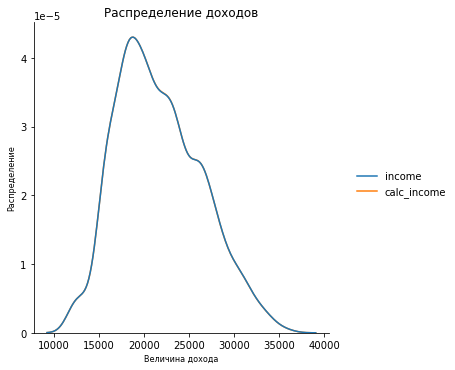

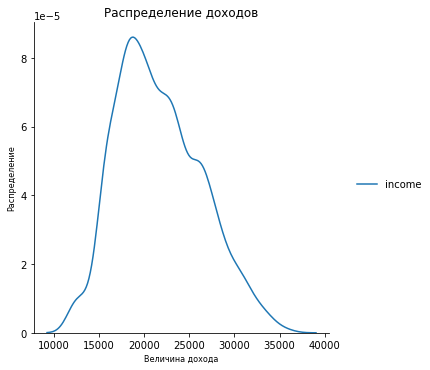

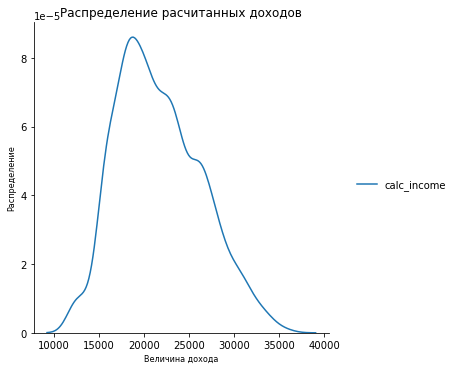

In [192]:
sns.displot(
    {
        "income": df.income,
        "calc_income": df.calc_income
    },
    kind="kde",
    
)
plt.title('Распределение доходов', fontsize=12)
plt.xlabel('Величина дохода', fontsize=8)
plt.ylabel('Распределение', fontsize=8)

# т к графики сливаются, нарисуем их по отдельности
sns.displot(
    {
        "income": df.income
    },
    kind="kde",
    
)
plt.title('Распределение доходов', fontsize=12)
plt.xlabel('Величина дохода', fontsize=8)
plt.ylabel('Распределение', fontsize=8)

sns.displot(
    {
        "calc_income": df.calc_income
    },
    color='0.8', 
    kind="kde",
    
)
plt.title('Распределение расчитанных доходов', fontsize=12)
plt.xlabel('Величина дохода', fontsize=8)
plt.ylabel('Распределение', fontsize=8)

Решение тестового задания окончено,
итоговую формулу можно посмотреть [здесь](#abcde)